# Overview

'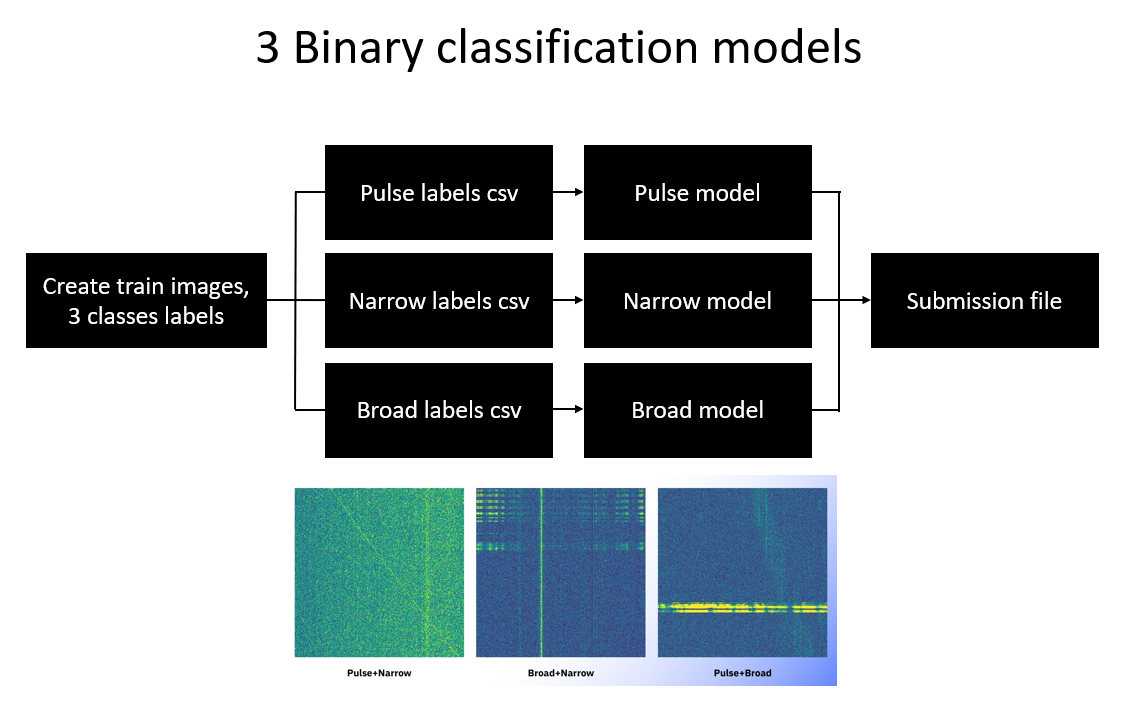'

In [2]:
!pip install kaggle -q

In [3]:
from google.colab import files
files.upload() # This will prompt you to upload kaggle.json

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle competitions download -c individual-test-fast-radio-burst-detection

 99% 13.8G/13.9G [00:51<00:00, 249MB/s]
100% 13.9G/13.9G [00:51<00:00, 289MB/s]


# Data Preparation

In [5]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import cv2

In [6]:
!unzip /content/individual-test-fast-radio-burst-detection.zip

Archive:  /content/individual-test-fast-radio-burst-detection.zip
  inflating: sample_submission.csv   
  inflating: test/test/0.npy         
  inflating: test/test/1.npy         
  inflating: test/test/10.npy        
  inflating: test/test/11.npy        
  inflating: test/test/12.npy        
  inflating: test/test/13.npy        
  inflating: test/test/14.npy        
  inflating: test/test/15.npy        
  inflating: test/test/16.npy        
  inflating: test/test/17.npy        
  inflating: test/test/18.npy        
  inflating: test/test/19.npy        
  inflating: test/test/2.npy         
  inflating: test/test/20.npy        
  inflating: test/test/21.npy        
  inflating: test/test/22.npy        
  inflating: test/test/23.npy        
  inflating: test/test/24.npy        
  inflating: test/test/25.npy        
  inflating: test/test/26.npy        
  inflating: test/test/27.npy        
  inflating: test/test/28.npy        
  inflating: test/test/29.npy        
  inflating: test/test

## Create test and train image

### train

In [7]:
def isNaN(num): # is nan
    return num != num

# create folder for train images
save_image_path = "train_images"
if not os.path.exists(save_image_path):
    os.makedirs(save_image_path)

# set up csv
train_csv = pd.DataFrame()
image_path = []
pulse_label = []
broad_label = []
narrow_label = []

# save train images and save train.csv
npy_path = "train/train"
csv_path = "train-labels-corrected/train"
csv_list = os.listdir(csv_path)
for i, npy_name in enumerate(tqdm(csv_list)): # loop file name in folder and load .npy and label csv
    train_label = pd.read_csv(f"{csv_path}/{npy_name}")
    npy = np.load(f"{npy_path}/{npy_name}".replace("_labels.csv",".npy"))
    npy = npy.reshape(int(npy.shape[0]/256), 256, 256)
    for j, img in enumerate(npy): # loop .npy every 256 row
        # create and save images
        if img.dtype != np.uint8:
            img = (255 * (img - img.min()) / (img.max() - img.min())).astype(np.uint8)
        save_path = f"{save_image_path}/{i}_{j}.jpg"
        cv2.imwrite(save_path, img)
        # save image path and label
        label = train_label["labels"][j]
        is_pulse = 0
        is_broad = 0
        is_narrow = 0
        if not isNaN(label):
            if "Pulse" in label:
                is_pulse = 1
            if "Broad" in label:
                is_broad = 1
            if "Narrow" in label:
                is_narrow = 1

        image_path.append(save_path)
        pulse_label.append(is_pulse)
        broad_label.append(is_broad)
        narrow_label.append(is_narrow)

# save .csv
train_csv["image_path"] = image_path
train_csv["pulse"] = pulse_label
train_csv["broad"] = broad_label
train_csv["narrow"] = narrow_label

train_csv.to_csv("train.csv", index = False)

100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


### test

In [8]:
# create folder for test images
save_image_path = "test_images"
if not os.path.exists(save_image_path):
    os.makedirs(save_image_path)

# save train images
npy_path = "test/test"
npy_list = os.listdir(f"{npy_path}")
for npy_name in tqdm(npy_list): # loop file name in folder and load .npy
    i = npy_name.split(".")[0] # use name from test.npy
    npy = np.load(f"{npy_path}/{npy_name}")
    npy = npy.reshape(int(npy.shape[0]/256), 256, 256)
    for j, img in enumerate(npy): # loop .npy every 256 row and save test images
        if img.dtype != np.uint8:
            img = (255 * (img - img.min()) / (img.max() - img.min())).astype(np.uint8)
        save_path = f"test_images/{i}_{j}.jpg"
        cv2.imwrite(save_path, img)

test_cav = pd.read_csv(f"sample_submission.csv", usecols=['id'])
test_cav["prediction"] = None
test_cav['id'] = test_cav['id'].apply(lambda x :  f"test_images/{x}.jpg")
test_cav.to_csv("test.csv", index = False)

100%|██████████| 33/33 [00:23<00:00,  1.41it/s]


# Train image by classification models

1. Albumentations

![](https://albumentations.ai/docs/images/introduction/image_augmentation/augmentation.jpg)

2. Use Cross Validation Kfold

![](https://user-images.githubusercontent.com/26833433/258589390-8d815058-ece8-48b9-a94e-0e1ab53ea0f6.png)

3. F1-score

![](https://iamirmasoud.com/wp-content/uploads/2023/04/image-33.png)

![](https://iamirmasoud.com/wp-content/uploads/2023/04/image-34.png)

In [12]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import gc
from fastai.vision.all import *
import albumentations
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform
import timm

## Select model

Training code ref:
https://github.com/TeetouchQQ

timm leaderboard:
https://github.com/pprp/timm/blob/master/results/results-imagenet.csv

EVA02:
https://huggingface.co/timm/eva02_base_patch14_224.mim_in22k

MaxViT:
https://huggingface.co/timm/maxvit_base_tf_224.in1k

In [13]:
timm.list_models("eva02*",pretrained=False)

['eva02_base_patch14_224',
 'eva02_base_patch14_448',
 'eva02_base_patch16_clip_224',
 'eva02_enormous_patch14_clip_224',
 'eva02_large_patch14_224',
 'eva02_large_patch14_448',
 'eva02_large_patch14_clip_224',
 'eva02_large_patch14_clip_336',
 'eva02_small_patch14_224',
 'eva02_small_patch14_336',
 'eva02_tiny_patch14_224',
 'eva02_tiny_patch14_336']

## Function

In [14]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

class AlbumentationsTransform (RandTransform):
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()

    def before_call(self, b, split_idx):
        self.idx = split_idx

    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

def auto_contrast(img):
    hist, bins = np.histogram(img.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    cdf_m = np.ma.masked_equal(cdf_normalized, 0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf = np.ma.filled(cdf_m, 0).astype('uint8')
    min_intensity = np.argmin(cdf)
    max_intensity = np.argmax(cdf)
    scale_factor = 255.0 / (max_intensity - min_intensity)
    img = (img - min_intensity) * scale_factor
    img = np.clip(img, 0, 255)
    return img.astype('uint8')


class AutoContrast(ImageOnlyTransform):
    def init(self, always_apply=False, p=1.0):
        super().init(always_apply=always_apply, p=p)
    def apply(self, img, **params):
        return auto_contrast(img)
    def get_transform_init_args_names(self):
        return ()

def get_train_aug(): return albumentations.Compose([
            albumentations.Resize(always_apply=False, p=1.0, height=size, width=size, interpolation=0),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
    ], p=1.)



def get_valid_aug(): return albumentations.Compose([
            albumentations.Resize(always_apply=False, p=1.0, height=size, width=size, interpolation=0),
            ], p=1.0)

def get_data(fold=0):
    return DataBlock(blocks=(ImageBlock,CategoryBlock),
                       get_x=ColReader(0),
                       get_y=ColReader(1),
                       splitter=IndexSplitter(train_df[train_df.fold == fold].index),
                       item_tfms=item_tfms,
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                      ).dataloaders(train_df, bs=batch)



In [15]:
for name in ["pulse","broad","narrow"]:
    train_df = pd.read_csv(f"train.csv", usecols=['image_path', name])
    negative = len(train_df[train_df[name] == 0])
    positive = len(train_df[train_df[name] == 1])
    total = negative + positive
    print(f"{name} {round(negative/total,2)}:{round(positive/total,2)}")

pulse 0.96:0.04
broad 0.97:0.03
narrow 0.91:0.09


In [ ]:
# model_name = 'eva02_base_patch14_224'
# size = 224
# downsampling = 1
# n_splits = 5
# ensemble_round = 3
# epochs = 10
# batch = 32

In [16]:
model_name = 'eva02_tiny_patch14_224'
size = 224
downsampling = 0.2
n_splits = 5
ensemble_round = 3
epochs = 10
batch = 128

save_csv_path = "csv"
if not os.path.exists(save_csv_path):
    os.makedirs(save_csv_path)

In [ ]:
train_list = ["pulse","broad","narrow"]

for name in train_list:
    # load train csv
    train_df = pd.read_csv(f"train.csv", usecols=['image_path', name])
    # downsampling class 0
    negative = train_df[train_df[name] == 0]
    positive = train_df[train_df[name] == 1]
    negative_random = negative.sample(n = int(len(negative)*downsampling))
    train_df = pd.concat([positive, negative_random], ignore_index=True, sort=False)
    # kfold
    strat_kfold = MultilabelStratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)
    train_df['fold'] = -1
    for i, (_, test_index) in enumerate(strat_kfold.split(train_df.image_path.values, train_df.iloc[:,1:].values)):
        train_df.iloc[test_index, -1] = i
    # augmentation
    warnings.filterwarnings('ignore')
    item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
    # load train csv
    test_df = pd.read_csv('test.csv')
    tstpng = test_df.copy()
    tstpng.head()

    all_preds = []
    mixup = MixUp(1.)
    print(name)
    for i in range(ensemble_round):
        print('Round',i+1)
        dls = get_data(i)
        learn = cnn_learner(dls, model_name,metrics=[accuracy,F1Score(average='macro')],cbs= [SaveModelCallback(monitor='f1_score'),mixup]).to_fp16()
        learn.fine_tune(epochs)

        tst_dl = learn.dls.test_dl(tstpng)
        preds, conf = learn.get_preds(dl=tst_dl)
        all_preds.append(preds)

        del learn
        torch.cuda.empty_cache()
        gc.collect()

    sub = pd.read_csv('test.csv')
    preds = np.mean(np.stack(all_preds), axis=0)
    preds = torch.from_numpy(preds)

    idxs = preds.argmax(dim=1)
    vocab = np.array(dls.vocab)
    sub['label'] = vocab[idxs]

    prop_1 = []
    prop_2 = []
    for prop in preds:
        prop_1.append(float(prop[0]))
        prop_2.append(float(prop[1]))

    sub['prop_0'] = prop_1
    sub['prop_1'] = prop_2

    sub.to_csv(f"csv/sub_{name}.csv", index = False)

pulse
Round 1


model.safetensors:   0%|          | 0.00/22.0M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.578229,0.216264,0.919822,0.837477,00:17


Better model found at epoch 0 with f1_score value: 0.837477241384303.


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.361543,0.161503,0.963474,0.932104,00:19
1,0.324155,0.134074,0.969710,0.945047,00:19
2,0.287192,0.140461,0.971938,0.949143,00:19
3,0.266861,0.127155,0.974833,0.955090,00:19
4,0.255828,0.119132,0.973719,0.952217,00:19
5,0.254008,0.119210,0.977060,0.958760,00:19
6,0.247182,0.107911,0.977283,0.959138,00:19
7,0.240037,0.107386,0.977728,0.959939,00:19
8,0.235765,0.099744,0.977728,0.959939,00:19
9,0.234124,0.101336,0.978174,0.960783,00:19


Better model found at epoch 0 with f1_score value: 0.9321039084234453.
Better model found at epoch 1 with f1_score value: 0.9450469742898602.
Better model found at epoch 2 with f1_score value: 0.9491426874207125.
Better model found at epoch 3 with f1_score value: 0.9550903464116314.
Better model found at epoch 5 with f1_score value: 0.9587596561054516.
Better model found at epoch 6 with f1_score value: 0.9591382468792926.
Better model found at epoch 7 with f1_score value: 0.9599394577247967.
Better model found at epoch 9 with f1_score value: 0.9607825311942959.


Round 2


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.590435,0.241850,0.903988,0.788058,00:16


Better model found at epoch 0 with f1_score value: 0.7880580423040643.


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.372179,0.133394,0.963243,0.930946,00:19
1,0.315468,0.173079,0.967699,0.944397,00:19
2,0.290706,0.113485,0.976832,0.958946,00:19
3,0.269276,0.110405,0.977946,0.960569,00:19
4,0.260050,0.096554,0.979728,0.963717,00:19
5,0.255030,0.092260,0.980174,0.964701,00:19
6,0.242051,0.089002,0.980619,0.965531,00:19
7,0.235170,0.094105,0.981956,0.968009,00:19
8,0.241445,0.088744,0.981733,0.967529,00:19
9,0.240622,0.085775,0.982179,0.968354,00:19


Better model found at epoch 0 with f1_score value: 0.930946323033993.
Better model found at epoch 1 with f1_score value: 0.9443969628280876.
Better model found at epoch 2 with f1_score value: 0.9589459917873693.
Better model found at epoch 3 with f1_score value: 0.9605694258601558.
Better model found at epoch 4 with f1_score value: 0.9637173491981426.
Better model found at epoch 5 with f1_score value: 0.9647014397963234.
Better model found at epoch 6 with f1_score value: 0.9655308576946557.
Better model found at epoch 7 with f1_score value: 0.9680085695495048.
Better model found at epoch 9 with f1_score value: 0.9683539841974362.


Round 3


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.574132,0.233009,0.913121,0.815029,00:16


Better model found at epoch 0 with f1_score value: 0.8150285902653633.


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.363843,0.148214,0.963466,0.931794,00:19
1,0.310966,0.148945,0.973045,0.951858,00:19
2,0.286207,0.117999,0.973936,0.952850,00:19
3,0.259759,0.126247,0.975273,0.955555,00:19
4,0.256403,0.105597,0.975941,0.957008,00:19


Better model found at epoch 0 with f1_score value: 0.9317935376758906.
Better model found at epoch 1 with f1_score value: 0.9518579743370277.
Better model found at epoch 2 with f1_score value: 0.9528496738116675.
Better model found at epoch 3 with f1_score value: 0.9555545386990176.
Better model found at epoch 4 with f1_score value: 0.9570075589623896.


In [ ]:
import pandas as pd
sub = pd.read_csv("sample_submission.csv")
sub_1 = pd.read_csv("csv/sub_broad.csv")
sub_2 = pd.read_csv("csv/sub_narrow.csv")
sub_3 = pd.read_csv("csv/sub_pulse.csv")

# pulse = []
# for i in range(len(sub_3)):
#     try:
#         if sub_3["label"][i] == 0 and sub_3["label"][i+1] == 1 and sub_3["label"][i+2] == 0:
#             pulse.append(1)
#         elif sub_3["label"][i-2] == 0 and sub_3["label"][i-1] == 1 and sub_3["label"][i] == 0:
#             pulse.append(1)
#         else:
#             pulse.append(sub_3["label"][i])
#     except:
#         pulse.append(sub_3["label"][i])
# sub_3["label"] = pulse


pulse = []
broad = []
narrow = []

for i in range(len(sub)):
    pulse.append(sub_3["label"][i])
    broad.append(sub_1["label"][i])
    narrow.append(sub_2["label"][i])

sub["pulse"] = pulse
sub["broad"] = broad
sub["narrow"] = narrow

sub.to_csv(f"submission_final_2.csv", index = False)

In [ ]:
import pandas as pd
sub = pd.read_csv("sample_submission.csv")
sub_1 = pd.read_csv("csv/sub_broad.csv")
sub_2 = pd.read_csv("csv/sub_narrow.csv")
sub_3 = pd.read_csv("csv/sub_pulse.csv")

# pulse = []
# for i in range(len(sub_3)):
#     try:
#         if sub_3["label"][i] == 0 and sub_3["label"][i+1] == 1 and sub_3["label"][i+2] == 0:
#             pulse.append(1)
#         elif sub_3["label"][i-2] == 0 and sub_3["label"][i-1] == 1 and sub_3["label"][i] == 0:
#             pulse.append(1)
#         else:
#             pulse.append(sub_3["label"][i])
#     except:
#         pulse.append(sub_3["label"][i])
# sub_3["label"] = pulse


pulse = []
broad = []
narrow = []

for i in range(len(sub)):
    pulse.append(sub_3["label"][i])
    broad.append(sub_1["label"][i])
    narrow.append(sub_2["label"][i])

sub["pulse"] = pulse
sub["broad"] = broad
sub["narrow"] = narrow

sub.to_csv(f"submission_final_2_new.csv", index = False)

# To improve

1. Preprecess images
2. Use ensemble submission
3. Use pseudo labeling to generate more train images for train
4. Use Test-Time Augmentation (TTA) to predict
5. Upsampling